# MLFF (Machine Learning Force Field) Tutorial with CHGNet

This tutorial demonstrates how to use CHGNet for structure relaxation and energy/force prediction compared with DFT results.

## What is CHGNet?

CHGNet (Crystal Hamiltonian Graph neural Network) is a pretrained universal neural network potential that can predict:
- **Energy** (eV/atom)
- **Forces** (eV/Å)
- **Stress** (GPa)
- **Magnetic moments** (μB)

It was trained on over 1.5 million structures from the Materials Project database and provides near-DFT accuracy for atomistic simulations.


In [1]:
#check the current path
import os
print(os.getcwd())

#Lists the files in the current directory
!ls
!git clone https://github.com/hguangshuai/intro_ML_for_MSE
%cd intro_ML_for_MSE

# Install required packages
%pip install chgnet
%pip install pymatgen
%pip install matplotlib
%pip install numpy

print("✓ All packages installed successfully!")
#MatBench Leaderboard
#https://matbench-discovery.materialsproject.org/

/content
sample_data
Cloning into 'intro_ML_for_MSE'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 2), reused 27 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 775.65 KiB | 24.24 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/intro_ML_for_MSE
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 k

In [2]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Import pymatgen for structure handling
from pymatgen.core import Structure
from pymatgen.io.vasp import Poscar

# Import CHGNet components
from chgnet.model.model import CHGNet
from chgnet.model import StructOptimizer

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


In [3]:
# Load CHGNet model
print("Loading CHGNet model...")
chgnet = CHGNet.load()
print("✓ CHGNet model loaded successfully!")

Loading CHGNet model...
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda
✓ CHGNet model loaded successfully!


In [17]:
# Load one POSCAR file using pymatgen Structure.from_str() method
file_path = '/content/intro_ML_for_MSE/Data/poscar/LiOSi_-7.0131.poscar'

print(f"Loading {file_path}...")
filename = os.path.basename(file_path)
dft_energy = float(filename.split('_')[1].replace('.poscar', ''))




# Read POSCAR file content as string
with open(file_path, 'r') as f:
    poscar_str = f.read()

# Use pymatgen to read POSCAR from string
structure = Structure.from_str(poscar_str, fmt="poscar")

print(f"✓ Successfully loaded {file_path}")
print(f"Composition: {structure.composition}")
print(f"Formula: {structure.formula}")
print(f"Atoms: {len(structure)}")
print(f"DFT Energy: {dft_energy:.6f} eV/atom")
print(structure)

Loading /content/intro_ML_for_MSE/Data/poscar/LiOSi_-7.0131.poscar...
✓ Successfully loaded /content/intro_ML_for_MSE/Data/poscar/LiOSi_-7.0131.poscar
Composition: Li4 O10 Si4
Formula: Li4 Si4 O10
Atoms: 18
DFT Energy: -7.013100 eV/atom
Full Formula (Li4 Si4 O10)
Reduced Formula: Li2Si2O5
abc   :   8.036192   8.036192   4.880914
angles:  90.000000  90.000000 136.693980
pbc   :       True       True       True
Sites (18)
  #  SP         a       b      c
---  ----  ------  ------  -----
  0  Li    0.279   0.389   0.525
  1  Li    0.389   0.279   0.025
  2  Li    0.611   0.721   0.025
  3  Li    0.721   0.611   0.525
  4  O     0.026   0.526   0.943
  5  O     0.526   0.026   0.443
  6  O     0.96    0.24    0.54
  7  O     0.24    0.96    0.04
  8  O     0.76    0.04    0.04
  9  O     0.04    0.76    0.54
 10  O     0.2615  0.4035  0.948
 11  O     0.4035  0.2615  0.448
 12  O     0.5965  0.7385  0.448
 13  O     0.7385  0.5965  0.948
 14  Si    0.0087  0.3057  0.879
 15  Si    0.3057  

In [15]:
from chgnet.model import StructOptimizer

relaxer = StructOptimizer()
result = relaxer.relax(structure)
print("CHGNet relaxed structure", result["final_structure"])
print("relaxed total energy in eV:", result['trajectory'].energies[-1])

#get No. of atoms
print("No. of atoms:", len(structure))

#calculate energy per atom
print("Energy per atom:", result['trajectory'].energies[-1] / len(structure))

#calculate force magnitude
print("Force magnitude:", np.linalg.norm(result['trajectory'].forces[-1]))



CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda
      Step     Time          Energy          fmax
FIRE:    0 01:30:10     -131.799774        2.387991
FIRE:    1 01:30:10     -131.997681        1.126893
FIRE:    2 01:30:10     -132.133484        1.016283
FIRE:    3 01:30:10     -132.184219        1.959407
FIRE:    4 01:30:11     -132.218552        1.595806
FIRE:    5 01:30:11     -132.266296        0.977060
FIRE:    6 01:30:11     -132.301086        0.417284
FIRE:    7 01:30:11     -132.311188        0.658335
FIRE:    8 01:30:11     -132.312637        0.635304
FIRE:    9 01:30:11     -132.315292        0.590782
FIRE:   10 01:30:11     -132.318970        0.527852
FIRE:   11 01:30:11     -132.323318        0.451235
FIRE:   12 01:30:11     -132.328064        0.370003
FIRE:   13 01:30:11     -132.332932        0.360643
FIRE:   14 01:30:11     -132.337677        0.350051
FIRE:   15 01:30:12     -132.342911        0.336182
FIRE:   16 01:30:12     -132.348709        0

In [14]:
# After relaxation
chgnet_energy_per_atom = result['trajectory'].energies[-1] / len(structure)
print(f"\nEnergy Comparison:")
print(f"DFT Energy: {dft_energy:.6f} eV/atom")
print(f"CHGNet Energy: {chgnet_energy_per_atom:.6f} eV/atom")
print(f"Difference: {abs(dft_energy - chgnet_energy_per_atom):.6f} eV/atom")


Energy Comparison:
DFT Energy: -7.013100 eV/atom
CHGNet Energy: -7.359092 eV/atom
Difference: 0.345992 eV/atom


In [13]:
# Calculate force statistics
forces = result['trajectory'].forces[-1]
force_magnitudes = np.linalg.norm(forces, axis=1)
print(f"\nForce Statistics:")
print(f"Max force: {np.max(force_magnitudes):.6f} eV/Å")
print(f"Mean force: {np.mean(force_magnitudes):.6f} eV/Å")
print(f"Min force: {np.min(force_magnitudes):.6f} eV/Å")


Force Statistics:
Max force: 0.075006 eV/Å
Mean force: 0.041215 eV/Å
Min force: 0.012336 eV/Å


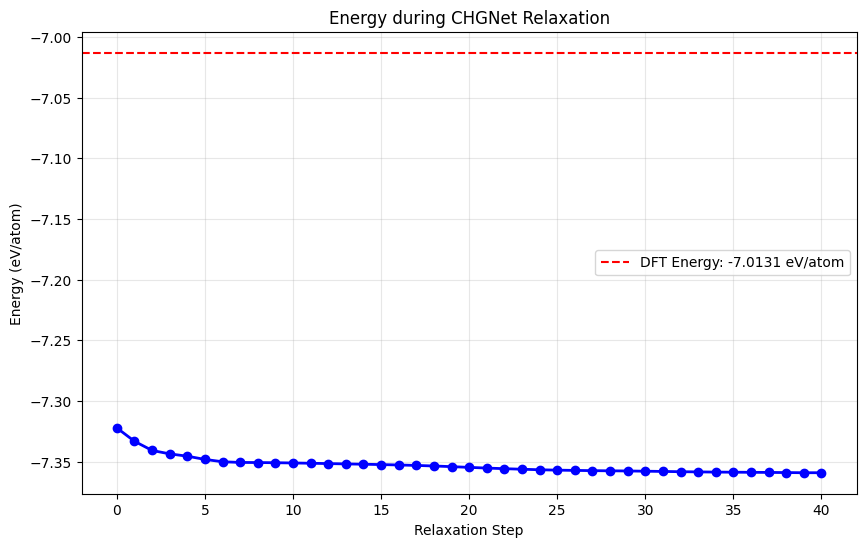

In [16]:
# 5. Optional: Add visualization
# Plot energy vs relaxation step
plt.figure(figsize=(10, 6))
energies_per_atom = [e / len(structure) for e in result['trajectory'].energies]
plt.plot(energies_per_atom, 'b-', linewidth=2, marker='o', markersize=6)
plt.axhline(y=dft_energy, color='r', linestyle='--', label=f'DFT Energy: {dft_energy:.4f} eV/atom')
plt.xlabel('Relaxation Step')
plt.ylabel('Energy (eV/atom)')
plt.title('Energy during CHGNet Relaxation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Compare initial and final structures
from pymatgen.analysis.structure_matcher import StructureMatcher

matcher = StructureMatcher()
is_same = matcher.fit(structure, result["final_structure"])
rms_dist = matcher.get_rms_dist(structure, result["final_structure"])

print(f"\nStructural Changes:")
print(f"Structures are similar: {is_same}")
if rms_dist:
    print(f"RMS displacement: {rms_dist[0]:.6f} Å")

# Volume change
initial_volume = structure.volume
final_volume = result["final_structure"].volume
volume_change = (final_volume - initial_volume) / initial_volume * 100

print(f"Initial volume: {initial_volume:.3f} Cu. Å")
print(f"Final volume: {final_volume:.3f} Cu. Å")
print(f"Volume change: {volume_change:.2f}%")


Structural Changes:
Structures are similar: True
RMS displacement: 0.054927 Å
Initial volume: 216.202 Cu. Å
Final volume: 218.164 Cu. Å
Volume change: 0.91%


#Optimizing all POSCAR files in the directory


In [20]:
# Process multiple POSCAR files to see trends
import glob
import pandas as pd

# Get all POSCAR files
poscar_files = glob.glob('/content/intro_ML_for_MSE/Data/poscar/*.poscar')
print(f"Found {len(poscar_files)} POSCAR files")

# Process first 10 files (or adjust as needed)
results_summary = []
n_files = min(10, len(poscar_files))  # Process up to 10 files

for i, file_path in enumerate(poscar_files[:n_files]):
    print(f"\nProcessing file {i+1}/{n_files}: {os.path.basename(file_path)}")

    try:
        filename = os.path.basename(file_path)
        dft_energy = float(filename.split('_')[1].replace('.poscar', ''))

        with open(file_path, 'r') as f:
            structure = Structure.from_str(f.read(), fmt="poscar")

        # Relax with CHGNet
        result = relaxer.relax(structure, verbose=False)
        chgnet_energy = result['trajectory'].energies[-1] / len(structure)

        # Calculate forces
        final_forces = result['trajectory'].forces[-1]
        max_force = np.max(np.linalg.norm(final_forces, axis=1))

        results_summary.append({
            'formula': structure.formula,
            'n_atoms': len(structure),
            'dft_energy': dft_energy,
            'chgnet_energy': chgnet_energy,
            'difference': chgnet_energy - dft_energy,
            'max_force': max_force,
            'n_steps': len(result['trajectory'].energies)
        })

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(results_summary)
print("\n" + "="*80)
print("SUMMARY OF RESULTS")
print("="*80)
print(df_results.to_string(index=False))

Found 6 POSCAR files

Processing file 1/6: BaFPd_-5.28347.poscar

Processing file 2/6: LiOSi_-7.0131.poscar

Processing file 3/6: AgAsO_-5.18793.poscar

Processing file 4/6: AlBaPt_-4.63365.poscar

Processing file 5/6: HgORu_-5.41213.poscar

Processing file 6/6: FeLaO_-8.04788.poscar

SUMMARY OF RESULTS
    formula  n_atoms  dft_energy  chgnet_energy  difference  max_force  n_steps
Ba4 Pd2 F12       18    -5.28347      -5.558939   -0.275469   0.073636       16
Li4 Si4 O10       18    -7.01310      -7.359090   -0.345990   0.075012       41
Ag8 As8 O28       44    -5.18793      -5.599171   -0.411241   0.020077       69
Ba2 Al4 Pt2        8    -4.63365      -4.656397   -0.022748   0.072004       26
 Hg2 Ru2 O4        8    -5.41213      -5.807776   -0.395647   0.060467       56
La4 Fe4 O12       20    -8.04788      -8.449387   -0.401506   0.058922       31


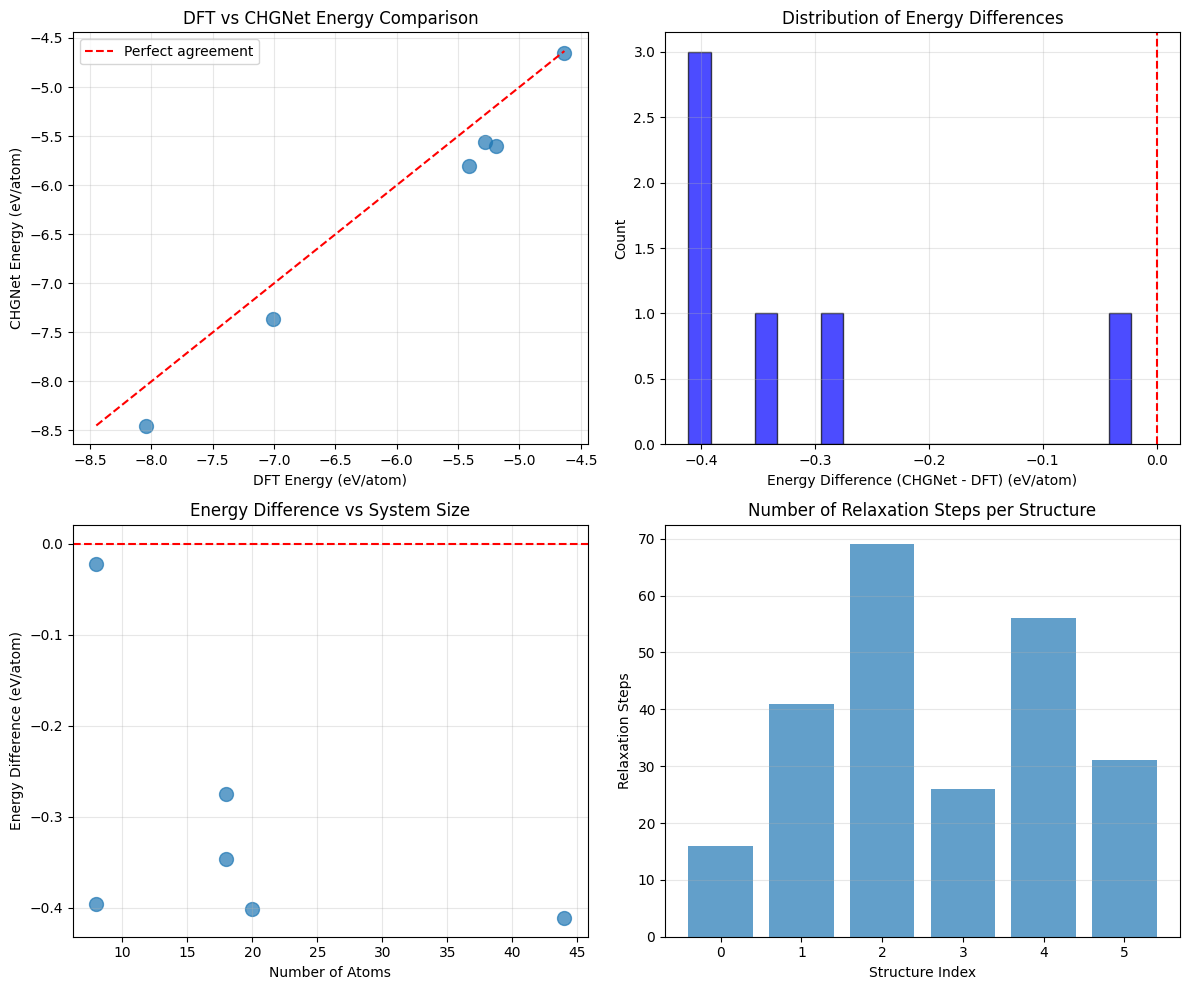


STATISTICS:
Mean energy difference: -0.3088 ± 0.1490 eV/atom
Mean absolute error: 0.3088 eV/atom
Max absolute error: 0.4112 eV/atom
Percentage with CHGNet < DFT: 100.0%


In [21]:
# Create visualization of DFT vs CHGNet energies
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Parity plot
ax1 = axes[0, 0]
ax1.scatter(df_results['dft_energy'], df_results['chgnet_energy'], alpha=0.7, s=100)
min_e = min(df_results['dft_energy'].min(), df_results['chgnet_energy'].min())
max_e = max(df_results['dft_energy'].max(), df_results['chgnet_energy'].max())
ax1.plot([min_e, max_e], [min_e, max_e], 'r--', label='Perfect agreement')
ax1.set_xlabel('DFT Energy (eV/atom)')
ax1.set_ylabel('CHGNet Energy (eV/atom)')
ax1.set_title('DFT vs CHGNet Energy Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Energy difference histogram
ax2 = axes[0, 1]
ax2.hist(df_results['difference'], bins=20, alpha=0.7, color='blue', edgecolor='black')
ax2.set_xlabel('Energy Difference (CHGNet - DFT) (eV/atom)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Energy Differences')
ax2.axvline(x=0, color='red', linestyle='--', label='Zero difference')
ax2.grid(True, alpha=0.3)

# 3. Energy difference vs composition size
ax3 = axes[1, 0]
ax3.scatter(df_results['n_atoms'], df_results['difference'], alpha=0.7, s=100)
ax3.set_xlabel('Number of Atoms')
ax3.set_ylabel('Energy Difference (eV/atom)')
ax3.set_title('Energy Difference vs System Size')
ax3.axhline(y=0, color='red', linestyle='--')
ax3.grid(True, alpha=0.3)

# 4. Convergence steps
ax4 = axes[1, 1]
ax4.bar(range(len(df_results)), df_results['n_steps'], alpha=0.7)
ax4.set_xlabel('Structure Index')
ax4.set_ylabel('Relaxation Steps')
ax4.set_title('Number of Relaxation Steps per Structure')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("\nSTATISTICS:")
print(f"Mean energy difference: {df_results['difference'].mean():.4f} ± {df_results['difference'].std():.4f} eV/atom")
print(f"Mean absolute error: {df_results['difference'].abs().mean():.4f} eV/atom")
print(f"Max absolute error: {df_results['difference'].abs().max():.4f} eV/atom")
print(f"Percentage with CHGNet < DFT: {(df_results['difference'] < 0).sum() / len(df_results) * 100:.1f}%")

In [22]:
# Group by chemical composition patterns
# Extract elements from formulas
df_results['elements'] = df_results['formula'].apply(lambda x: ''.join([c for c in x if c.isalpha()]))

# Group by element combinations
element_groups = df_results.groupby('elements').agg({
    'difference': ['mean', 'std', 'count'],
    'formula': 'first'
}).round(4)

print("\nENERGY DIFFERENCES BY ELEMENT COMBINATION:")
print(element_groups)

# Check if certain elements lead to larger differences
all_elements = set()
for formula in df_results['formula']:
    all_elements.update([c for c in formula if c.isalpha()])

element_differences = {}
for element in all_elements:
    mask = df_results['formula'].str.contains(element)
    if mask.sum() > 0:
        element_differences[element] = df_results.loc[mask, 'difference'].mean()

# Sort by difference
sorted_elements = sorted(element_differences.items(), key=lambda x: x[1])
print("\nAVERAGE ENERGY DIFFERENCE BY ELEMENT PRESENCE:")
for element, diff in sorted_elements:
    count = df_results['formula'].str.contains(element).sum()
    print(f"{element}: {diff:+.4f} eV/atom (in {count} structures)")


ENERGY DIFFERENCES BY ELEMENT COMBINATION:
         difference                formula
               mean std count        first
elements                                  
AgAsO       -0.4112 NaN     1  Ag8 As8 O28
BaAlPt      -0.0227 NaN     1  Ba2 Al4 Pt2
BaPdF       -0.2755 NaN     1  Ba4 Pd2 F12
HgRuO       -0.3956 NaN     1   Hg2 Ru2 O4
LaFeO       -0.4015 NaN     1  La4 Fe4 O12
LiSiO       -0.3460 NaN     1  Li4 Si4 O10

AVERAGE ENERGY DIFFERENCE BY ELEMENT PRESENCE:
s: -0.4112 eV/atom (in 1 structures)
g: -0.4034 eV/atom (in 2 structures)
e: -0.4015 eV/atom (in 1 structures)
H: -0.3956 eV/atom (in 1 structures)
u: -0.3956 eV/atom (in 1 structures)
R: -0.3956 eV/atom (in 1 structures)
O: -0.3886 eV/atom (in 4 structures)
L: -0.3737 eV/atom (in 2 structures)
S: -0.3460 eV/atom (in 1 structures)
i: -0.3460 eV/atom (in 1 structures)
F: -0.3385 eV/atom (in 2 structures)
d: -0.2755 eV/atom (in 1 structures)
a: -0.2332 eV/atom (in 3 structures)
A: -0.2170 eV/atom (in 2 structures)
P: 


CHGNet PREDICTIONS (without relaxation):
Total energy: -8.3283 eV
Energy per atom: -0.4164 eV/atom
Forces shape: (20, 3)
Max force component: 0.4782 eV/Å
Stress tensor (GPa):
[[15.959055   0.987478  -3.2624562]
 [ 0.9874792 17.140305  -2.7632852]
 [-3.2624557 -2.7632847 16.451023 ]]
Magnetic moments: [4.3546968  4.3587637  4.3499284  4.3615494  0.03682828 0.03682835
 0.03457215 0.03457228 0.15661132 0.15661144 0.15697032 0.1569711
 0.16382605 0.16382545 0.1140624  0.11406314 0.15964913 0.15965009
 0.11664003 0.11664104]


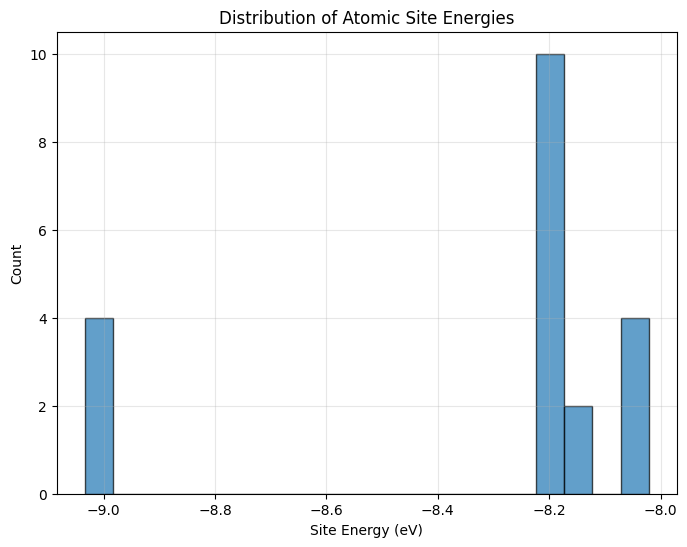

In [23]:
# Test energy and force predictions without relaxation
test_structure = structure  # Use the last loaded structure

# Get predictions without relaxation
prediction = chgnet.predict_structure(
    test_structure,
    return_site_energies=True,
    return_atom_feas=False,
    return_crystal_feas=False
)

print("\nCHGNet PREDICTIONS (without relaxation):")
print(f"Total energy: {prediction['e']:.4f} eV")
print(f"Energy per atom: {prediction['e']/len(test_structure):.4f} eV/atom")
print(f"Forces shape: {prediction['f'].shape}")
print(f"Max force component: {np.abs(prediction['f']).max():.4f} eV/Å")
print(f"Stress tensor (GPa):")
print(prediction['s'])
if 'm' in prediction:
    print(f"Magnetic moments: {prediction['m']}")

# Visualize site energies if available
if 'site_energies' in prediction:
    plt.figure(figsize=(8, 6))
    site_energies = prediction['site_energies']
    plt.hist(site_energies, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Site Energy (eV)')
    plt.ylabel('Count')
    plt.title('Distribution of Atomic Site Energies')
    plt.grid(True, alpha=0.3)
    plt.show()


Linear Correction Model:
Slope: 1.0592
Intercept: 0.0425


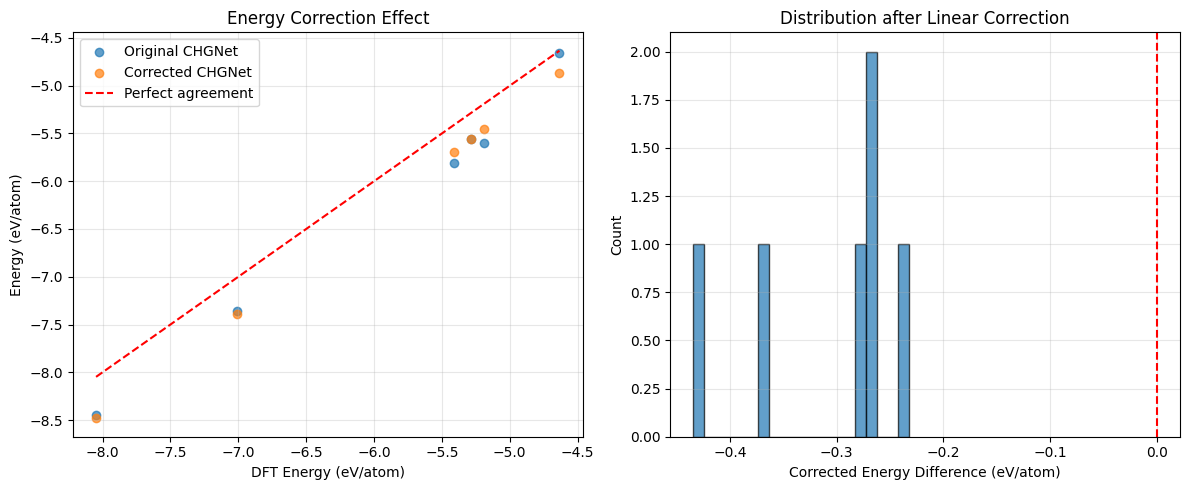


After correction:
Mean absolute error: 0.3088 eV/atom
Max absolute error: 0.4342 eV/atom


In [24]:
# Calculate a simple linear correction
from sklearn.linear_model import LinearRegression

# Fit linear model
X = df_results['dft_energy'].values.reshape(-1, 1)
y = df_results['chgnet_energy'].values
model = LinearRegression()
model.fit(X, y)

print(f"\nLinear Correction Model:")
print(f"Slope: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

# Apply correction
df_results['chgnet_corrected'] = model.predict(X)
df_results['corrected_difference'] = df_results['chgnet_corrected'] - df_results['dft_energy']

# Plot corrected results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df_results['dft_energy'], df_results['chgnet_energy'], alpha=0.7, label='Original CHGNet')
plt.scatter(df_results['dft_energy'], df_results['chgnet_corrected'], alpha=0.7, label='Corrected CHGNet')
plt.plot([df_results['dft_energy'].min(), df_results['dft_energy'].max()],
         [df_results['dft_energy'].min(), df_results['dft_energy'].max()], 'r--', label='Perfect agreement')
plt.xlabel('DFT Energy (eV/atom)')
plt.ylabel('Energy (eV/atom)')
plt.title('Energy Correction Effect')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df_results['corrected_difference'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Corrected Energy Difference (eV/atom)')
plt.ylabel('Count')
plt.title('Distribution after Linear Correction')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAfter correction:")
print(f"Mean absolute error: {df_results['corrected_difference'].abs().mean():.4f} eV/atom")
print(f"Max absolute error: {df_results['corrected_difference'].abs().max():.4f} eV/atom")

In [25]:
# Example: Calculate formation energy
# Using LiOSi as example
li_osi_structure = structure  # Your loaded structure

# Reference energies (you would need actual values)
# These are example values - replace with real reference energies
ref_energies = {
    'Li': -1.90,  # eV/atom
    'O': -4.95,   # eV/atom
    'Si': -5.43   # eV/atom
}

# Calculate formation energy
composition = li_osi_structure.composition
total_atoms = sum(composition.values())

# DFT formation energy
dft_total = dft_energy * total_atoms
ref_total = sum(composition[el] * ref_energies.get(str(el), 0) for el in composition)
dft_formation = (dft_total - ref_total) / total_atoms

# CHGNet formation energy
chgnet_total = chgnet_energy_per_atom * total_atoms
chgnet_formation = (chgnet_total - ref_total) / total_atoms

print("\nFORMATION ENERGY CALCULATION:")
print(f"Composition: {composition}")
print(f"DFT formation energy: {dft_formation:.4f} eV/atom")
print(f"CHGNet formation energy: {chgnet_formation:.4f} eV/atom")
print(f"Difference: {chgnet_formation - dft_formation:.4f} eV/atom")


FORMATION ENERGY CALCULATION:
Composition: Fe4 La4 O12
DFT formation energy: -5.0779 eV/atom
CHGNet formation energy: -4.3891 eV/atom
Difference: 0.6888 eV/atom


In [26]:
import time

# Benchmark CHGNet vs DFT computational cost
print("\nCOMPUTATIONAL PERFORMANCE:")

# Time CHGNet prediction
start = time.time()
for _ in range(10):
    prediction = chgnet.predict_structure(test_structure)
chgnet_time = (time.time() - start) / 10

# Time CHGNet relaxation
start = time.time()
result = relaxer.relax(test_structure, steps=50)
relax_time = time.time() - start

print(f"CHGNet single-point prediction: {chgnet_time*1000:.2f} ms")
print(f"CHGNet relaxation (50 steps): {relax_time:.2f} s")
print(f"Typical DFT single-point: ~60-300 s (100-1000x slower)")
print(f"Typical DFT relaxation: ~1-10 hours (1000-10000x slower)")

# Calculate speedup
speedup_prediction = 180 / chgnet_time  # Assuming 3 min for DFT
speedup_relaxation = 3600 / relax_time  # Assuming 1 hour for DFT

print(f"\nEstimated speedup:")
print(f"Single-point: {speedup_prediction:.0f}x")
print(f"Relaxation: {speedup_relaxation:.0f}x")


COMPUTATIONAL PERFORMANCE:
      Step     Time          Energy          fmax
FIRE:    0 01:39:36     -166.566345        1.528820
FIRE:    1 01:39:36     -166.657730        1.496869
FIRE:    2 01:39:36     -166.833435        1.437507
FIRE:    3 01:39:37     -167.079865        1.348030
FIRE:    4 01:39:37     -167.375717        1.235303
FIRE:    5 01:39:37     -167.695328        1.090944
FIRE:    6 01:39:37     -168.003296        0.910340
FIRE:    7 01:39:37     -168.266266        0.715137
FIRE:    8 01:39:37     -168.465820        0.513846
FIRE:    9 01:39:37     -168.573013        0.361672
FIRE:   10 01:39:37     -168.612915        0.310816
FIRE:   11 01:39:37     -168.613556        0.360351
FIRE:   12 01:39:37     -168.620316        0.357148
FIRE:   13 01:39:38     -168.633286        0.350823
FIRE:   14 01:39:38     -168.651276        0.341734
FIRE:   15 01:39:38     -168.672867        0.330807
FIRE:   16 01:39:38     -168.696594        0.319432
FIRE:   17 01:39:38     -168.721100   